# Calculating the coefficient of variation of the cumulative plots of radial analysis

In [19]:
import sys
sys.path.append('../')

import calculate_radial_analysis as calculate
import tools
import render

import json
import glob
import os
import re
import numpy as np
import math
from natsort import natsorted
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

# Automatically read parameters from input directory

In [20]:
single_cell_heatmap_location = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/wt_control_wt_div'
analysis_info = single_cell_heatmap_location.split('individual_spatiotemporal_heatmaps/')[1]
radius, t_range, num_bins = list(map(int,analysis_info.split('/')[0].split('.') ))
focal_cell, focal_event , subject_cell, subject_event = analysis_info.split('/')[1].split('_')
save_parent_dir = os.path.join('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/statistics')

## Compile individual heatmaps into cumulative plots 

Compile cumulative heatmap by iteratively adding single-apoptosis heatmaps from previous output or different pre-established output 

In [21]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    if 'N_cells' in heatmap_ID:
        N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
    if 'N_events' in heatmap_ID:
        N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        N+=1
P_events = N_events/N_cells
N

2453

In [17]:
print("The number of {} cells counted is equal to = ".format(subject_cell), N_cells.sum())

The number of wt cells counted is equal to =  45385756.0


Function to plot heatmaps: 

`render.auto_plot_cumulative(input_2d_hist, input_type, num_bins, radius, t_range, title, expt_label, cb_label, save_path, SI = True)`

Where the variables needed are as follows:

- `input_2d_hist` = Input 2D histogram
- `input_type` = String version of input variable name
- `num_bins` = Number of bins the histogram is sorted into
- `radius` = Spatial extent of scan
- `t_range` = Temporal range of scan
- `focal_cell` = Cell type that is the focal point of the scan 
- `focal_event` = Event type that is the focal point of the scan 
- `subject_cell` = Cell type that is scanned over
- `subject_event` = Event type that is the scanned over 
- `save_parent_dir` = Root directory into which different plots will be saved according to scan parameters, if empty then plots not saved out 
- `cbar_lim` = Tuple that is the limits of the colorbar, if left blank then will be automatically decided
- `include_apop_bin` = Boolean option to include the first spatial bin (which for 40px/13um bins usually only includes the site of apoptosis)
- `SI` = If True then plots the xy in SI base unit instead of pixel/frames

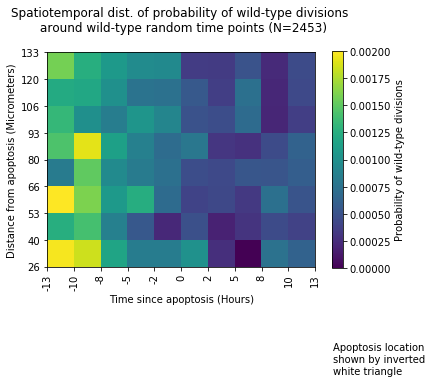

In [22]:
render.auto_plot_cumulative(P_events,
                     'P_events',
                      N,
                      num_bins  ,
                      radius ,
                      t_range , 
                      focal_cell, 
                      focal_event, 
                      subject_cell, 
                      subject_event, 
                      '',#save_parent_dir ,
                      cbar_lim = (0,0.002),
                      include_apop_bin = False,
                      SI = True)

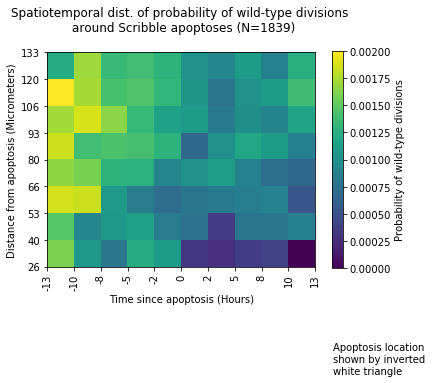

In [14]:
render.auto_plot_cumulative(P_events,
                     'P_events',
                      N,
                      num_bins  ,
                      radius ,
                      t_range , 
                      focal_cell, 
                      focal_event, 
                      subject_cell, 
                      subject_event, 
                      '',#save_parent_dir ,
                      cbar_lim = (0,0.002),
                      include_apop_bin = False,
                      SI = True)

# sandbox

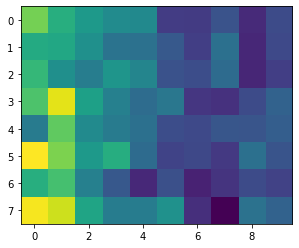

In [92]:

plt.imshow(np.flipud(P_events[1:-1,:]))


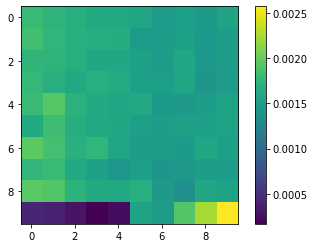

In [68]:
plt.imshow(np.flipud(P_events))
plt.colorbar()

In [93]:
def auto_plot_cumulative(input_2d_hist, input_type, N, num_bins, radius, t_range, focal_cell, focal_event, subject_cell, subject_event, save_parent_dir, cbar_lim, include_apop_bin, SI):

        xlocs, xlabels, ylocs, ylabels = kymo_labels(num_bins, 1, radius, t_range, SI)

        ## formatting cell and event names
        focal_event_name = 'apoptoses' if 'apop' in focal_event.lower() else 'divisions' #focal_event == 'APOPTOSIS' or 'apop' else 'divisions'
        focal_cell_name = 'wild-type' if 'wt' in focal_cell.lower() else 'Scribble'
        subj_event_name = 'apoptoses' if 'apop' in subject_event.lower() else 'divisions'
        subj_cell_name = 'wild-type' if 'wt' in subject_cell.lower() else 'Scribble'

        if focal_event == 'control':
            focal_event_name = 'random time points'

        title = 'Spatiotemporal dist. of probability of {} {} \n around {} {} (N={})'.format(subj_cell_name, subj_event_name, focal_cell_name, focal_event_name, N)

        ## output save path formatting
        save_dir_name = '{}_{}_{}_{}'.format(focal_cell.lower(), focal_event.lower()[0:3] if focal_event == 'DIVISION' else focal_event.lower()[0:4], subject_cell.lower(), subject_event.lower()[0:3] if subject_event == 'DIVISION' else subject_event.lower()[0:4])
        save_dir = '{}.{}.{}/{}'.format(radius,t_range,num_bins,save_dir_name)
        save_path = os.path.join(save_parent_dir,save_dir)
        Path(save_path).mkdir(parents=True, exist_ok=True)

        ## title formatting
        if input_type == 'N_cells':
            title = 'Spatiotemporal dist. of {} cells \n around {} {} (N={})'.format(subj_cell_name,focal_cell_name, focal_event_name, N)
            cb_label = 'Number of {} cell apperances'.format(subj_cell_name)
        if input_type == 'N_events':
            title = 'Spatiotemporal dist. of {} {} \n around {} {} (N={})'.format(subj_cell_name, subj_event_name, focal_cell_name, focal_event_name, N)
            cb_label = 'Number of {} {}'.format(subj_cell_name, subj_event_name)
        if input_type == 'P_events':
            title = 'Spatiotemporal dist. of probability of {} {} \n around {} {} (N={})'.format(subj_cell_name, subj_event_name, focal_cell_name, focal_event_name, N)
            cb_label = 'Probability of {} {}'.format(subj_cell_name, subj_event_name)

        ## label unit formatting
        if SI == True:
            time_unit = '(Hours)'
            distance_unit = '(Micrometers)'
        else:
            time_unit = '(Frames)'
            distance_unit = '(Pixels)'

        ## plotting
        plt.xticks(xlocs, xlabels, rotation = 'vertical')
        plt.yticks(ylocs, ylabels)
        plt.xlabel("Time since apoptosis "+ time_unit)
        plt.ylabel("Distance from apoptosis "+ distance_unit)
        plt.title(title+'\n')

        ## if include_apop_bin is true then the spatial bin containing the apoptotic cell (ie the central spatial bin of the radial scan) will be show in the graph, if false then it is cropped which ends up with a plot showing only the relevant local env not the site of apop (better imo)
        if include_apop_bin == True:    
            final_hist = np.flipud(input_2d_hist)  ## flip for desired graph orientation
        else:
            final_hist = np.flipud(input_2d_hist[1:-1,:])
        
        plt.imshow(final_hist)

        if cbar_lim == '':
            plt.colorbar(label = cb_label)
        else:
            plt.clim(vmin=cbar_lim[0], vmax=cbar_lim[1])
            plt.colorbar(label = cb_label)

        ## apop location marker
        plt.scatter(num_bins/2-0.5, num_bins-0.75, s=20, c='white', marker='v')
        plt.text(num_bins+0.15, num_bins+1.5, 'Apoptosis location \nshown by inverted \nwhite triangle')

        fn = os.path.join(save_path,title+'.pdf')

        ## failsafe overwriting block
        if os.path.exists(fn):
            print("Filename", fn, "already exists, saving as updated copy")
            fn = fn.replace('.pdf', ' (updated {}).pdf'.format(time.strftime("%Y%m%d-%H%M%S")))


        ## save out?
        if save_parent_dir == '':
            return plt.imshow(final_hist)
        else:
            plt.savefig(fn, dpi = 300, bbox_inches = 'tight')
            print("Plot saved at ", fn)
            return plt.imshow(final_hist)

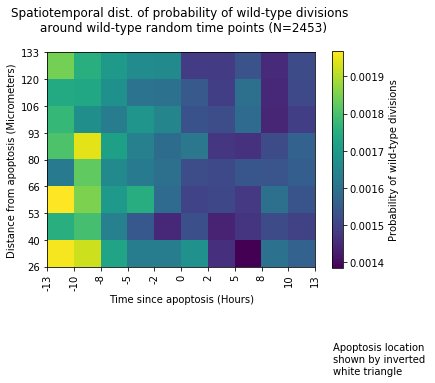

In [95]:
def kymo_labels(num_bins, label_freq, radius, t_range, SI):
    label_freq = 1
    radial_bin = radius / num_bins
    temporal_bin = t_range / num_bins

    if SI == True:
        time_scale_factor = 4/60 ## each frame is 4 minutes
        distance_scale_factor = 1/3 ## each pixel is 0.3recur micrometers
    else:
        time_scale_factor, distance_scale_factor = 1,1

    ### generate labels for axis micrometers/hours
    xlocs = np.arange(-0.5, num_bins, label_freq) ## -0.5 to start at far left border of first bin
    xlabels = []
    for m in np.arange(int(-num_bins/2), int(num_bins/2)+1,label_freq):
        xlabels.append(str(int(((temporal_bin)*m)*time_scale_factor)))# + "," + str(int(((temporal_bin)*m+temporal_bin)*time_scale_factor)))
    
    ylocs = np.arange(-0.5, num_bins, label_freq) ## -0.5 to start at far top border of first bin
    ylabels = []
    for m in np.arange(num_bins, 0-1, -label_freq):
        ylabels.append(str(int(((radial_bin)*m)*distance_scale_factor)))# + "," + str(int(((radial_bin)*(m-1)*distance_scale_factor))))

    return xlocs, xlabels, ylocs, ylabels

auto_plot_cumulative(P_events,
                     'P_events',
                      N,
                      num_bins  ,
                      radius ,
                      t_range , 
                      focal_cell, 
                      focal_event, 
                      subject_cell, 
                      subject_event, 
                      '',#save_parent_dir ,
                      '',
                      include_apop_bin=False,
                      SI = True)



400

# means

In [7]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    if 'N_cells' in heatmap_ID:
        N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        N += 1
    if 'N_events' in heatmap_ID:
        N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))

mean_N_cells = N_cells / N
mean_N_events = N_events / N

P_events = N_events / N_cells
mean_P_events = P_events / N

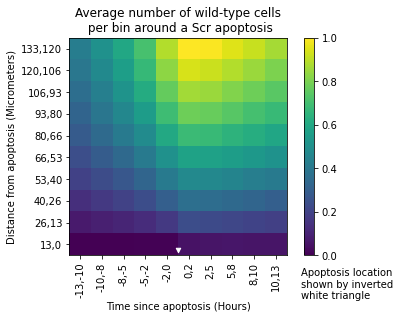

In [9]:
plt.imshow(np.flipud(mean_N_cells))
plt.title('Average number of wild-type cells\n per bin around a Scr apoptosis')
plot_labels(SI=True)
plt.colorbar()

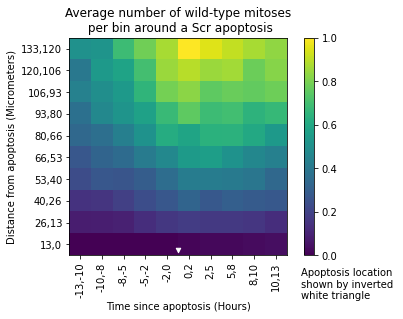

In [10]:
plt.imshow(np.flipud(mean_N_events))
plt.title('Average number of wild-type mitoses\n per bin around a Scr apoptosis')
plot_labels(SI=True)
plt.colorbar()

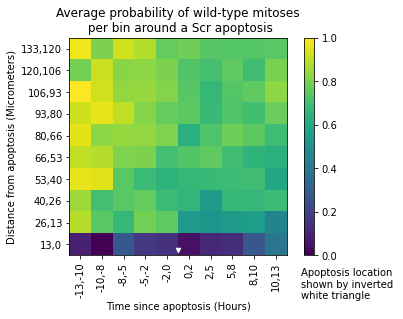

In [11]:
plt.imshow(np.flipud(mean_P_events))
plt.title('Average probability of wild-type mitoses\n per bin around a Scr apoptosis')
plot_labels(SI=True)
plt.colorbar()

# coeff var for N_cells

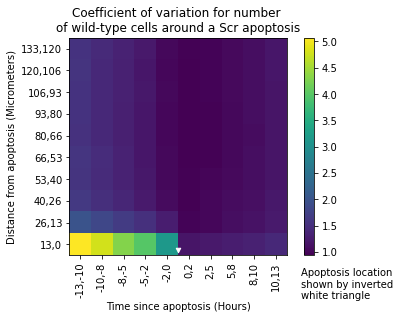

In [12]:
N_cells, sum_dev_sq = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    if 'N_cells' in heatmap_ID:
        N_cells = np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        dev = N_cells - mean_N_cells
        dev_sq = dev**2
        sum_dev_sq += dev_sq
        N+=1

### calculating the variance
var = sum_dev_sq / N
# plt.imshow(np.flipud(var))
# plt.colorbar()
### calculating the standard dev
st_dev = np.sqrt(sum_dev_sq / N)
# plt.imshow(np.flipud(st_dev))
# plt.colorbar()
### coeff of var
coeff_var = st_dev / mean_N_cells
plt.imshow(np.flipud(coeff_var))
plt.title('Coefficient of variation for number \nof wild-type cells around a Scr apoptosis')
plt.colorbar()
plot_labels(SI=True)
#plt.savefig('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coefficient of variation for number of wild-type cells around a Scr apoptosis.pdf', bbox_to_inches = 'tight')

# coeff var for N_events

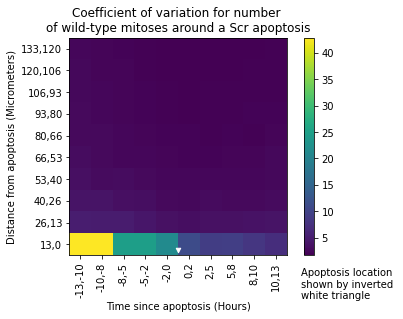

In [13]:
N_events, sum_dev_sq = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    if 'N_events' in heatmap_ID:
        N_events = np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        dev = N_events - mean_N_events
        dev_sq = dev**2
        sum_dev_sq += dev_sq
        N+=1

### calculating the variance
var = sum_dev_sq / N
# plt.imshow(np.flipud(var))
# plt.colorbar()
### calculating the standard dev
st_dev = np.sqrt(sum_dev_sq / N)
# plt.imshow(np.flipud(st_dev))
# plt.colorbar()
### coeff of var
coeff_var = st_dev / mean_N_events
plt.imshow(np.flipud(coeff_var))
plt.title('Coefficient of variation for number \nof wild-type mitoses around a Scr apoptosis')
plt.colorbar()
plot_labels(SI=True)
#plt.savefig('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coefficient of variation for number of wild-type mitoses around a Scr apoptosis.pdf', bbox_to_inches = 'tight')

# coeff var for P_events

<ipython-input-14-27321557b21b>:8: RuntimeWarning: invalid value encountered in true_divide
  P_events = np.nan_to_num(N_events/N_cells)


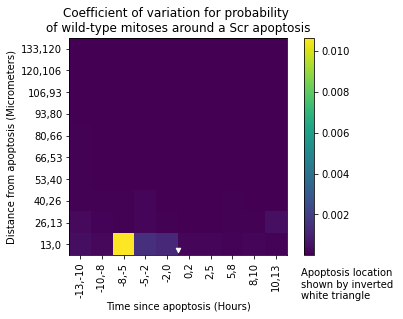

In [14]:
N_cells, sum_dev_sq = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    if 'N_cells' in heatmap_ID:
        N_cells = np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        heatmap_ID = heatmap_ID.split('N_')[0] + 'N_events.npy'
        N_events = np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        P_events = np.nan_to_num(N_events/N_cells)
        
        dev = P_events - mean_P_events
        dev_sq = dev**2
        sum_dev_sq += dev_sq
        N+=1
### calculating the variance
var = sum_dev_sq / N
# plt.imshow(np.flipud(var))
# plt.colorbar()
### calculating the standard dev
st_dev = np.sqrt(sum_dev_sq / N)
# plt.imshow(np.flipud(st_dev))
# plt.colorbar()
### coeff of var
coeff_var = st_dev / mean_N_cells
plt.imshow(np.flipud(coeff_var))
plt.title('Coefficient of variation for probability \nof wild-type mitoses around a Scr apoptosis')
plt.colorbar()
plot_labels(SI=True)
#plt.savefig('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coefficient of variation for probability of wild-type cells around a Scr apoptosis.pdf', bbox_to_inches = 'tight')

# Different definition of coeff var, not sure if correct

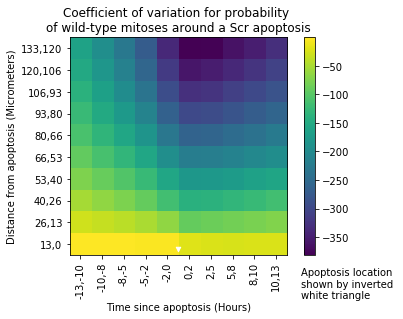

In [131]:
coeff_var = 1-st_dev / st_dev*mean_N_cells
plt.imshow(np.flipud(coeff_var))
plt.title('Coefficient of variation for probability \nof wild-type mitoses around a Scr apoptosis')
plt.colorbar()
plot_labels(SI=True)
#plt.savefig('/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/scan_parameterisation/Coefficient of variation for probability of wild-type cells around a Scr apoptosis.pdf', bbox_to_inches = 'tight')

# Statistics of rare events

Generally, to compare probability estimators, we determine if their values differ by more than their
absolute precision. This absolute precision is often estimated by the standard error

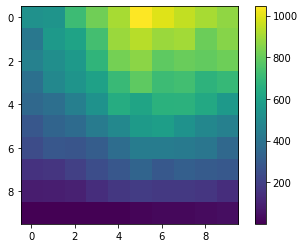

In [29]:
plt.imshow(np.flipud(N_events))
plt.colorbar()

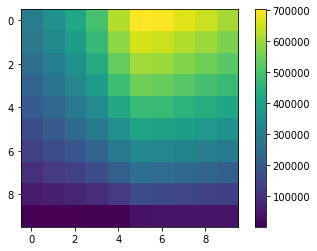

In [30]:
plt.imshow(np.flipud(N_cells))
plt.colorbar()

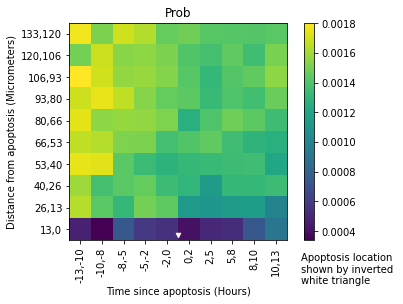

In [34]:
plt.imshow(np.flipud(P_events))
plt.title('Prob')
plt.colorbar()
plot_labels(SI=True)


In [31]:
p = P_events ## probability of event
n = N_events ## number of events
N = N_cells ## number of observations

#p = n/N 
SE = np.sqrt((p*(1-p))/N)

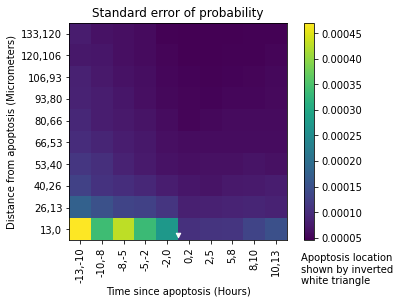

In [37]:
plt.imshow(np.flipud(SE))
plt.colorbar()
plt.title('Standard error of probability')
plot_labels(SI = True)

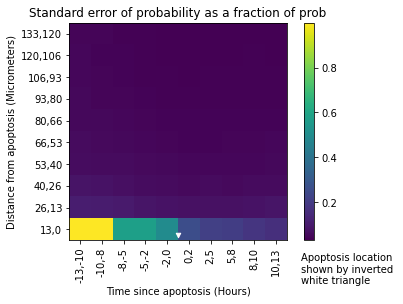

In [46]:
plt.imshow(np.flipud(SE/P_events))
plt.colorbar()
#plt.clim(0,0.25)
plt.title('Standard error of probability as a fraction of prob')
plot_labels(SI = True)

# True coeff of var

In [60]:
cv = np.sqrt(((1-p)/(p*N)))

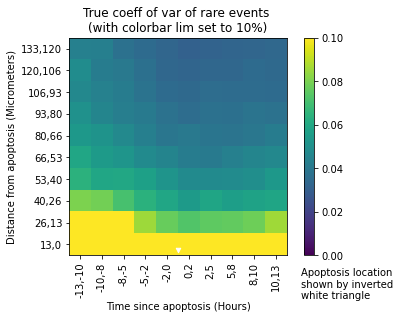

In [66]:
plt.imshow(np.flipud(cv))
plt.colorbar()
plt.clim(0,0.1)
plt.title('True coeff of var of rare events \n(with colorbar lim set to 10%)')
plot_labels(SI=True)

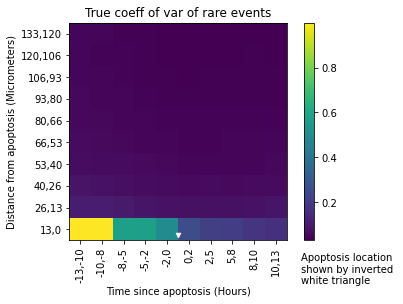

In [67]:
plt.imshow(np.flipud(cv))
plt.colorbar()
#plt.clim(0,0.1)
plt.title('True coeff of var of rare events')
plot_labels(SI=True)